### First I will conduct some analysis of the speeches, pointing out trends and cool facts. Then I will build the recommender.

In [1]:
import pandas as pd

In [2]:
sotu_df = pd.read_csv('formatted_sotu_dataframe.csv').drop('Unnamed: 0', axis=1)

In [3]:
sotu_df.head()

,president,year,title,text,party
0,Washington,1790,Washington_1790,"Fellow Citizens of the Senate, and House of Re...",Independent
1,Washington,1791,Washington_1791,Fellow-Citizens of the Senate and House of Rep...,Independent
2,Washington,1792,Washington_1792,Fellow-Citizens of the Senate and House of Rep...,Independent
3,Washington,1793,Washington_1793,Fellow-Citizens of the Senate and House of Rep...,Independent
4,Washington,1794,Washington_1794,Fellow-Citizens of the Senate and House of Rep...,Independent


## Text preparation
I will only remove the punctuation from each address. I don't want to remove all non-alphabetic characters because I want numbers to count toward speech length.

In [4]:
import string

In [5]:
# Add a special kind of apostrophe that appears in some transcripts.
punctuation = string.punctuation + "’"

In [6]:
def remove_punc(text):
    """
    Function takes a string as input, removes the
    punctuation and returns a clean string.
    """
    # Split on hyphenated words and em dashes, then rejoin them into a string and split again but on whitespace
    tokens = " ".join(text.split('-')).split('—')
    tokens = " ".join(tokens).split()

    # Remove punctuation
    table = str.maketrans("", "", punctuation)
    tokens = [w.translate(table) for w in tokens]

    # Ensure that all words are stripped of whitespace
    tokens = [word.strip() for word in tokens]
    
    return " ".join(tokens)

In [7]:
# Clean each speech in the dataset and store it in a new column titled "cleaned_text"
sotu_df['cleaned_text'] = sotu_df['text'].apply(remove_punc)

In [8]:
sotu_df.head()

,president,year,title,text,party,cleaned_text
0,Washington,1790,Washington_1790,"Fellow Citizens of the Senate, and House of Re...",Independent,Fellow Citizens of the Senate and House of Rep...
1,Washington,1791,Washington_1791,Fellow-Citizens of the Senate and House of Rep...,Independent,Fellow Citizens of the Senate and House of Rep...
2,Washington,1792,Washington_1792,Fellow-Citizens of the Senate and House of Rep...,Independent,Fellow Citizens of the Senate and House of Rep...
3,Washington,1793,Washington_1793,Fellow-Citizens of the Senate and House of Rep...,Independent,Fellow Citizens of the Senate and House of Rep...
4,Washington,1794,Washington_1794,Fellow-Citizens of the Senate and House of Rep...,Independent,Fellow Citizens of the Senate and House of Rep...


## Create a speech length feature and a readability feature, and add them to the dataframe.

#### Calculate the number of words in each address

In [9]:
sotu_df['word_count'] = sotu_df['cleaned_text'].apply(lambda x: len(x.split()))

#### Calculate the Flesch Reading Ease Score for each speech. For the Flesch score, a higher score means it's easier to read.

In [10]:
from textatistic import Textatistic

In [11]:
# Textatistic needs the string to have punctuation, so it will be fed the uncleaned text.
sotu_df['flesch_score'] = sotu_df['text'].apply(lambda x: Textatistic(x).scores['flesch_score'])

In [12]:
# Map the readability score to the associated grade level.
def readability_translation_to_grade(score):
    """
    Function takes a Flesch readability
    score as input and returns the grade
    level as a string.
    """
    if score >= 90.0:
        return '5th grade level'
    elif score >= 80.0:
        return '6th grade level'
    elif score >= 70.0:
        return '7th grade level'
    elif score >= 60.0:
        return '8th & 9th grade level'
    elif score >= 50.0:
        return '10th to 12th grade level'
    elif score >= 30.0:
        return 'College level'
    elif score >= 10.0:
        return 'College graduate level'
    elif score < 10.0:
        return 'Professional level'

In [13]:
# Add the new feature to the dataframe
sotu_df['reading_grade_level'] = sotu_df['flesch_score'].apply(readability_translation_to_grade)

In [14]:
sotu_df.head()

,president,year,title,text,party,cleaned_text,word_count,flesch_score,reading_grade_level
0,Washington,1790,Washington_1790,"Fellow Citizens of the Senate, and House of Re...",Independent,Fellow Citizens of the Senate and House of Rep...,1093,38.824272,College level
1,Washington,1791,Washington_1791,Fellow-Citizens of the Senate and House of Rep...,Independent,Fellow Citizens of the Senate and House of Rep...,2308,36.893961,College level
2,Washington,1792,Washington_1792,Fellow-Citizens of the Senate and House of Rep...,Independent,Fellow Citizens of the Senate and House of Rep...,2100,43.322286,College level
3,Washington,1793,Washington_1793,Fellow-Citizens of the Senate and House of Rep...,Independent,Fellow Citizens of the Senate and House of Rep...,1969,46.326339,College level
4,Washington,1794,Washington_1794,Fellow-Citizens of the Senate and House of Rep...,Independent,Fellow Citizens of the Senate and House of Rep...,2918,41.789635,College level


### Next, create a function to count the most common words in a single speech or a group of speeches
The idea is to be able to input a list of speeches from some grouping, such as all the speeches of a party or a particular president, and find the most commonly used words. The function will also be able to find the most common words in a single speech.

In [15]:
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.corpus import stopwords

In [16]:
def n_most_common_words(speeches, n_words=5):
    """
    Function takes a list or pandas Series of speeches 
    and returns the n_words most common words used in
    the provided corpus of speeches.
    """
    if (type(speeches) != list and type(speeches) != pd.core.series.Series):
        raise Exception("First argument must be a list or a pandas Series. For a single speech, make a singleton list.")
    master_string = " ".join(speeches)
    tokens = word_tokenize(master_string)
    
    # Remove stopwords, and add a few more terms to the nltk stopwords list
    stop_words = stopwords.words('english') + ['The', 'And', 'In', 'also', 'I', 'It', 'But', 'year', 'would']
    tokens = [word for word in tokens if word not in stop_words]
    counter = Counter(tokens)
    return counter.most_common(n_words)

### Now you have all the functions and data needed to compare speeches across presidents, parties, and time.

--------

# Analysis

### Superlatives: Which speeches and presidents stood out?

In [17]:
# Define a helper function to eliminate redundant code
def most_and_least(df, feature):
    """
    Function takes a dataframe as input, either a 
    regular one or one already grouped by a feature.
    Then it sorts the dataframe by the provided 'feature'
    and returns a tuple of the form: 
    (highest_observation, lowest_observation).
    """
    top_instance = df.sort_values(feature, ascending=False).iloc[0]
    bottom_instance = df.sort_values(feature, ascending=False).iloc[-1]
    return (top_instance, bottom_instance)

##### What were the longest and shortest speeches?

In [18]:
longest_speech, shortest_speech = most_and_least(sotu_df, 'word_count')

In [19]:
print('The longest speech was {title}, with a length of {length} words.'.format(title=longest_speech['title'], 
                                                                                length=longest_speech['word_count']))

print('The shortest speech was {title}, with a length of {length} words.'.format(title=shortest_speech['title'], 
                                                                                 length=shortest_speech['word_count']))

The longest speech was Carter_1981, with a length of 33840 words.
The shortest speech was Washington_1790, with a length of 1093 words.


Turns out, President Jimmy Carter's 1981 State of the Union was one of the only addresses in modern history that was written and delivered to Congress rather than given in person as a speech. This might explain why it was so long.

##### Which presidents had the longest and shortest speeches on average?

In [20]:
longest_on_avg, shortest_on_avg = most_and_least(sotu_df.groupby('president').mean(), 'word_count')

In [21]:
print('The president with the longest speeches on average was {name}. Average length: {length} words.'.format(
    name=longest_on_avg.name, length=longest_on_avg['word_count']))
print('The president with the shortest speeches on average was {name}. Average length: {length} words.'.format(
    name=shortest_on_avg.name, length=shortest_on_avg['word_count']))

The president with the longest speeches on average was Theodore Roosevelt. Average length: 19740.375 words.
The president with the shortest speeches on average was John Adams. Average length: 1789.25 words.


##### Which speeches were most and least readable?

In [22]:
most_readable, least_readable = most_and_least(sotu_df, 'flesch_score')

In [23]:
print('The most readable speech was {title}, with a {grade} readability.'.format(
    title=most_readable['title'], grade=most_readable['reading_grade_level']))

print('The least readable (most difficult to understand) speech was {title}, with a {grade} readability.'.format(
    title=least_readable['title'], grade=least_readable['reading_grade_level']))

The most readable speech was Bush_1992, with a 7th grade level readability.
The least readable (most difficult to understand) speech was Madison_1815, with a College graduate level readability.


##### Of the presidents that gave a State of the Union address, who gave the most and who gave the fewest addresses?
NOTE: Two presidents, William Henry Harrison and James A. Garfield, died in office before ever giving a State of the Union address.

In [24]:
# You can pass any feature name as the argument to sort by because all values in the count dataframe are the same
most_speeches, fewest_speeches = most_and_least(sotu_df.groupby('president').count(), 'year')

In [25]:
print("President {name} gave the most State of the Union addresses, with {count}.".format(name=most_speeches.name,
                                                                                count=most_speeches['year']))
print("President {name} gave the fewest State of the Union addresses, with {count}.".format(name=fewest_speeches.name,
                                                                                count=fewest_speeches['year']))

President Franklin Roosevelt gave the most State of the Union addresses, with 12.
President Taylor gave the fewest State of the Union addresses, with 1.


#### Create a function that returns the most common words used by a president.

In [26]:
def president_most_common(president_name, n_words=5):
    """
    Function takes a president's name as a string
    and a specified number of most common words and 
    returns the n_words most common words used by that president
    across his speeches. Provides a simpler interface to
    the n_most_common_words function.
    """
    return n_most_common_words(sotu_df[sotu_df['president'] == president_name]['cleaned_text'], n_words)

In [27]:
president_most_common('Obama')

[('We', 225), ('new', 201), ('America', 189), ('us', 184), ('people', 184)]

In [28]:
president_most_common('Trump')

[('American', 133),
 ('We', 129),
 ('America', 81),
 ('new', 79),
 ('Americans', 77)]

In [29]:
president_most_common('Reagan')

[('We', 174), ('us', 154), ('America', 127), ('must', 126), ('people', 122)]

In [30]:
president_most_common('Washington')

[('States', 91), ('United', 84), ('may', 63), ('public', 49), ('upon', 37)]

In [31]:
president_most_common('Kennedy')

[('new', 56), ('We', 43), ('world', 38), ('free', 36), ('nations', 30)]

### Comparisons across parties and time

To make comparisons acorss time, I will create 5 categories for the following time periods: 1790-1850, 1851-1900, 1901-1950, 1951-2000, 2001-2020.

In [32]:
def categorize_time_period(year):
    """
    Function takes an int representing the
    year the speech was given and returns the
    time period bucket the year falls into.
    """
    if year <= 1850:
        return '1790-1850'
    elif year <= 1900:
        return '1851-1900'
    elif year <= 1950:
        return '1901-1950'
    elif year <= 2000:
        return '1951-2000'
    else:
        return '2001-2020'

In [33]:
# Add a time period categorical column
sotu_df['time_period'] = sotu_df['year'].apply(categorize_time_period)

Create a function to help plot different features by party or time period.

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

In [35]:
party_colors = {
    'Whig': '#ffc680',
    'Democrat': 'blue',
    'Republican': 'red',
    'Democratic-Republican': '#a83266',
    'Federalist': '#000000',
    'Independent': '#808080'
}

In [36]:
def plot_grouped_by_feature(feature, df, title, x_label, y_label, palette='crest'):
    """
    Function takes a feature to plot; a dataframe;
    a plot title; an x label; a y label; and an optional
    color palette argument. Then it creates and plots
    a Seaborn bar plot.
    """
    plt.figure(figsize=(8, 7))
    splot = sns.barplot(x=df.index, y=feature, data=df, ci=None, palette=palette)

    for p in splot.patches:
        splot.annotate(format(p.get_height(), '.1f'), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points')
    
    plt.title(title, fontsize=18, pad=20)
    plt.xlabel(x_label, fontsize=14)
    plt.xticks(rotation=30)
    plt.ylabel(y_label, fontsize=14)
    plt.tight_layout()

#### Which party has given the most State of the Union addresses?

In [37]:
speech_count_by_party = sotu_df.groupby('party').count().sort_values('year', ascending=False)

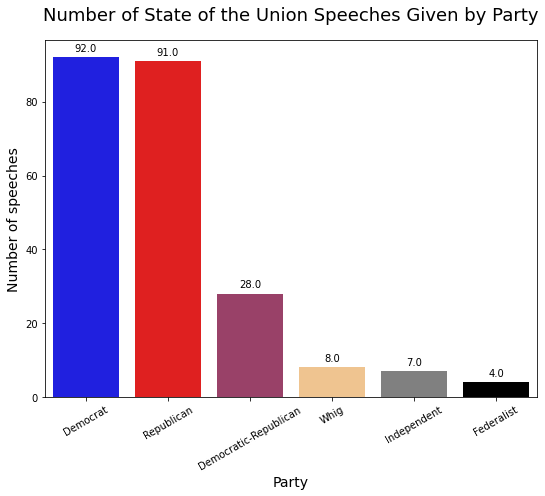

In [38]:
plot_grouped_by_feature('president', speech_count_by_party, 'Number of State of the Union Speeches Given by Party',
                        'Party', 'Number of speeches', party_colors)

The dominance of Democrats and Republicans should come as no surprise considering the fact that they have been the only major parties in the United States since the 1850s.

#### Compare the average speech lengths of the parties.

In [39]:
avg_length_by_party = sotu_df.groupby('party').mean().sort_values('word_count', ascending=False)

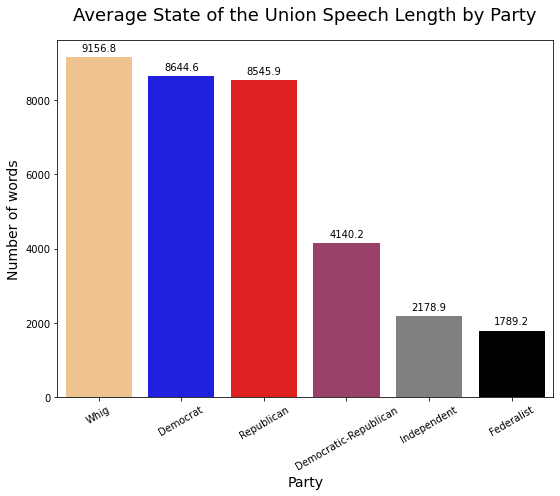

In [40]:
plot_grouped_by_feature('word_count', avg_length_by_party, 'Average State of the Union Speech Length by Party', 
                        'Party', 'Number of words', party_colors)

As you can see in the plot above, the Whig presidents of the first half of the 19th century were quite loquacious. Democrats and Republicans have, on average, given speeches of about the same length.

#### Compare the average speech lengths over time.

In [41]:
avg_length_over_time = sotu_df.groupby('time_period').mean()

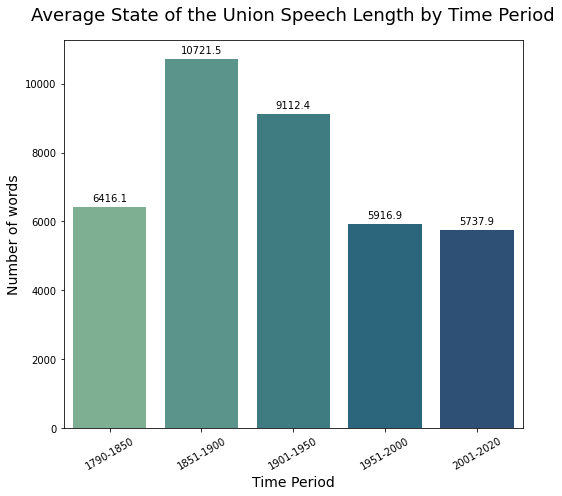

In [42]:
plot_grouped_by_feature('word_count', avg_length_over_time, 'Average State of the Union Speech Length by Time Period',
                        'Time Period', 'Number of words')

It's fascinating to see that since the first half of the 19th century, average speech lengths have decreased. After some further investigation, I learned that Thomas Jefferson started the tradition of delivering a written address to Congress rather than giving a speech in person. Therefore, from 1801 until 1913, the State of the Union address was not delivered by the president as a speech, but rather submitted to Congress as a written report. This written format likely explains why speeches in the time period 1851-1900 were so long. In fact, the most recent president to submit a written speech rather than give the speech in person was Jimmy Carter in 1981. As I showed earlier, this address was the longest ever, which indicates that there appears to be a relationship between the length of the address and the format.

One more interesting note is that speeches from the past 70 years have been shorter, on average, than those from earlier time periods. My guess would be that the rise of TV, and the limited attention span of TV audiences, has forced presidents to shorten their addresses.

#### Speech readability by party

In [43]:
readability_by_party = sotu_df.groupby('party').mean().sort_values('flesch_score', ascending=False)

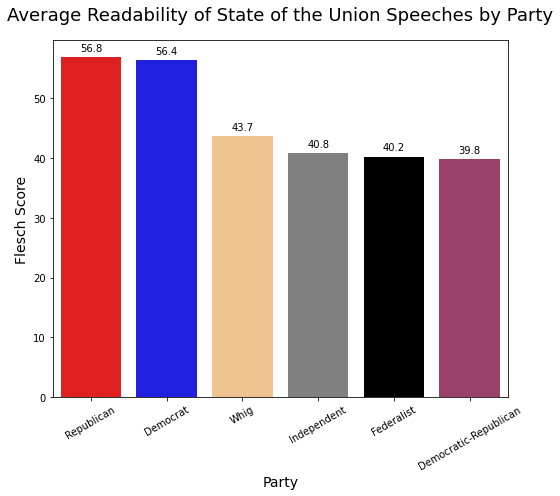

In [44]:
plot_grouped_by_feature('flesch_score', readability_by_party, 
                        'Average Readability of State of the Union Speeches by Party', 'Party', 'Flesch Score', 
                        party_colors)

Remember, a higher score means the speech is easier to understand. Therefore, Democrats and Republicans have the most readable speeches on average compared to the speeches of the other parties.

Republicans and Democrats on average have spoken at about a high school level (10th - 12th grade). All the other parties have spoken at a college level. However, none of these other parties have held the presidency since the 1850s, so it's possible that language changes since the 19th century account for most of these speeches' complexity.

#### Speech readability over time

In [45]:
readability_over_time = sotu_df.groupby('time_period').mean()

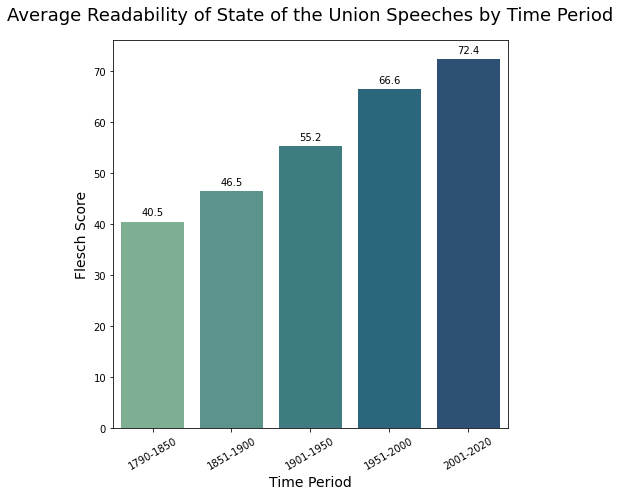

In [46]:
plot_grouped_by_feature('flesch_score', readability_over_time, 
                        'Average Readability of State of the Union Speeches by Time Period', 'Time Period', 
                        'Flesch Score')

There is a pretty clear trend toward speeches becoming more "readable" over time. There are probably a number of factors contributing to why this is the case, from mass media to language changes. 

One thing that's important to keep in mind though, is that readability scores are based on our education standards today. So when the Flesch Score says that speeches from 1790-1850 are at a college level, this means that college students today could understand the speech. It's not clear what level of education would have been required back then to understand the speeches.

#### Favorite words of Republicans and Democrats
These are the most common words from a corpus of all the Republican speeches and a corpus of all the Democratic speeches. In other words, if you consider all 91 Republican State of the Union addresses as a single text, these are the words that occurred the most often.

In [47]:
# Favorite Republican words
n_most_common_words(sotu_df[sotu_df['party'] == 'Republican']['cleaned_text'], 10)

[('States', 2495),
 ('Government', 2337),
 ('Congress', 2222),
 ('United', 1917),
 ('people', 1760),
 ('upon', 1667),
 ('American', 1520),
 ('must', 1505),
 ('We', 1505),
 ('made', 1430)]

In [48]:
# Favorite Democratic words
n_most_common_words(sotu_df[sotu_df['party'] == 'Democrat']['cleaned_text'], 10)

[('States', 2776),
 ('Government', 2358),
 ('Congress', 2151),
 ('people', 2010),
 ('United', 1976),
 ('We', 1948),
 ('upon', 1738),
 ('must', 1621),
 ('country', 1504),
 ('public', 1419)]

Republicans and Democrats share 8 words across their respective top 10 most common words lists.

#### Most common words over time

In [49]:
period_1 = sotu_df[sotu_df['time_period'] == '1790-1850']['cleaned_text']
period_2 = sotu_df[sotu_df['time_period'] == '1851-1900']['cleaned_text']
period_3 = sotu_df[sotu_df['time_period'] == '1901-1950']['cleaned_text']
period_4 = sotu_df[sotu_df['time_period'] == '1951-2000']['cleaned_text']
period_5 = sotu_df[sotu_df['time_period'] == '2001-2020']['cleaned_text']

In [50]:
print('1790-1850:', n_most_common_words(period_1, 5))
print('\n')
print('1851-1900:', n_most_common_words(period_2, 5))
print('\n')
print('1901-1950:', n_most_common_words(period_3, 5))
print('\n')
print('1951-2000:', n_most_common_words(period_4, 5))
print('\n')
print('2001-2020:', n_most_common_words(period_5, 5))
print('\n')

1790-1850: [('States', 1909), ('Government', 1488), ('United', 1369), ('may', 1209), ('public', 1132)]


1851-1900: [('States', 2778), ('Government', 2147), ('United', 1961), ('upon', 1639), ('Congress', 1597)]


1901-1950: [('Government', 1367), ('Congress', 1136), ('States', 1026), ('must', 1014), ('We', 1008)]


1951-2000: [('We', 1622), ('must', 1263), ('people', 1045), ('new', 1006), ('world', 934)]


2001-2020: [('We', 591), ('America', 478), ('people', 415), ('American', 402), ('new', 392)]




It's interesting to see the words 'new' and 'world' occur often in the post-World War II era. It likely reflects America's rise to world superpower during that time period.

-----------

# Content based recommendation  using semantic similarity

The recommender below creates TF-IDF vectors for each speech and then computes the cosine similarity for every speech against every other speech. Cosine similarity measures the similarity between two vectors, and in our case, vectors are just documents represented numerically. Therefore, what cosine similarity ends up measuring is simply the similarity between two documents.

Thus, for a given speech, the "recommended" speeches will be those with which it shares the highest cosine similarity.

In [51]:
# Create the TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(lowercase=False)

In [52]:
# Fit the TfidfVectorizer on the cleaned speeches corpus consisting of every speech

tfidf_matrix = tfidf.fit_transform(sotu_df['cleaned_text'])

In [53]:
# Generate the cosine similarity matrix
from sklearn.metrics.pairwise import linear_kernel

# Pass the tfidf_matrix as both arguments because you want the similarity of a speech with every other speech in 
# the corpus.
cosine_similarity = linear_kernel(tfidf_matrix, tfidf_matrix)

In [54]:
# Create a mapping between titles and index
indices = pd.Series(sotu_df.index, index=sotu_df['title'])

In [56]:
def recommend_speeches(title, cosine_similarity_matrix, indices):
    """
    Function takes a speech title, a cosine similarity
    matrix, and a Pandas series of indices and returns
    the titles of the top 10 most similar speeches.
    """
    idx = indices[title]
    
    # Sort the speeches by similarity score
    sim_scores = list(enumerate(cosine_similarity_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the top 10 most similar speeches (starts at index 1 because a speech's most similar speech will be itself)
    sim_scores = sim_scores[1:11]
    # Get the speech indices
    speech_indices = [i[0] for i in sim_scores]
    # Return the 10 most similar speeches
    return sotu_df['title'].iloc[speech_indices]

In [57]:
recommend_speeches('Lincoln_1864', cosine_similarity, indices)

58          Polk_1848
61      Fillmore_1851
99      Harrison_1889
48         Buren_1838
96     Cleveland_1886
47         Buren_1837
89         Hayes_1879
122         Taft_1912
95     Cleveland_1885
101     Harrison_1891
Name: title, dtype: object

In [58]:
recommend_speeches('Obama_2016', cosine_similarity, indices)

220      Obama_2011
224      Obama_2015
204    Clinton_1995
219      Obama_2010
223      Obama_2014
222      Obama_2013
221      Obama_2012
202    Clinton_1993
218      Obama_2009
207    Clinton_1998
Name: title, dtype: object

In [59]:
recommend_speeches('Trump_2020', cosine_similarity, indices)

228      Trump_2019
226      Trump_2017
227      Trump_2018
207    Clinton_1998
213       Bush_2004
176    Johnson_1967
177    Johnson_1968
215       Bush_2006
187     Carter_1978
216       Bush_2007
Name: title, dtype: object

#### EXTRA: One final cool thing you can do with the cosine similarity matrix is find the most unique State of the Union address. To do this, simply find the speech with the lowest average cosine similarity score across all its pairwise comparisons.

In [60]:
similarity_averages = []
for idx, row in enumerate(cosine_similarity):
    similarity_averages.append({'index': idx, 'mean_similarity': row.mean()})

In [61]:
most_unique_idx = sorted(similarity_averages, key=lambda x: x['mean_similarity'])[0]['index']

In [62]:
sotu_df.iloc[most_unique_idx]

president                                                 George W. Bush
year                                                                2001
title                                                          Bush_2001
text                   To the Congress of the United States:\n\nMr. S...
party                                                         Republican
cleaned_text           To the Congress of the United States Mr Speake...
word_count                                                          4386
flesch_score                                                     73.7629
reading_grade_level                                      7th grade level
time_period                                                    2001-2020
Name: 210, dtype: object

The most unique speech, as measured by its average cosine similarity with all the other State of the Union addresses, was President George W. Bush's 2001 address. 

I find this to be a very interesting, though not entirely surprising, result. This address was given in January 2001, months before 9/11 and just a few days after Bush became president. This was a moment in America when history seemed to stand still. The Cold War had been over for less than a decade and America was getting comfortable as the unrivaled world superpower; the US economy was flourishing after working its way out of a recession in the early 90s; the internet was booming; had America's future ever looked brighter?

Therefore, it's not surprising that this speech was unique. After 9/11, the president and the State of the Union would focus on the novel threat of international terrorism, and, in due time, the old speech topics of the economy, international tensions, and war would return.